In [1]:
EXP_NAME = "cb_sample_code"

In [2]:
import polars as pl
import numpy as np

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier, Pool
import seaborn as sns

In [3]:
import catboost

catboost.__version__

'1.2.7'

In [4]:
pl.__version__

'1.25.2'

In [5]:
train = pl.read_csv("../sample_data/train.csv")
test = pl.read_csv("../sample_data/test.csv")

In [6]:
train.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [7]:
USE_COL = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
CATEGORICAL_FEATURE = ["Sex", "Embarked"]
TARGET_COL = "Survived"
FOLD_NUM = 5
SEED = 42
NUM_BOOST_ROUND = 10000
EARLY_STOPPING_ROUNDS = 100
VERBOSE_EVAL = 100

In [8]:
# 欠損値の処理
# CatBoostは、カテゴリ列にNoneを含む場合、np.nanに変換しておく必要がある。
for cat_col in CATEGORICAL_FEATURE:
    train = train.with_columns(pl.col(cat_col).replace(None, np.nan))
    test = test.with_columns(pl.col(cat_col).replace(None, np.nan))

In [9]:
# Categorical型への変換
for cat_col in CATEGORICAL_FEATURE:
    train = train.with_columns(pl.col(cat_col).cast(pl.Categorical))
    test = test.with_columns(pl.col(cat_col).cast(pl.Categorical))

In [10]:
# Foldの作成
fold_arr = np.zeros(train.height)
fold = KFold(n_splits=FOLD_NUM, shuffle=True, random_state=SEED)

for idx, (_, val_idx) in enumerate(fold.split(train)):
    fold_arr[val_idx] = idx

train = train.with_columns(pl.Series(fold_arr).cast(pl.Int64).alias("fold"))

In [11]:
import sys

sys.path.append("/root/atmacup19")
from src.feature_engineering.table import add_target_encoding

# Pclassごとのtarget encodingの実装
TARGET_ENCODING_COL = ["Pclass", "Sex"]

train, test, add_col = add_target_encoding(
    train, test, FOLD_NUM, TARGET_COL, TARGET_ENCODING_COL
)

USE_COL += add_col

In [12]:
# CatBoost のパラメータ
# LightGBM のパラメータと呼び方が少し異なるため注意
cat_params = {
    "iterations": NUM_BOOST_ROUND,  # num_boost_roundと同等
    "learning_rate": 0.01,  # learning_rate
    "depth": 6,  # max_depth の代わり
    "random_seed": SEED,  # ランダムシード
    "l2_leaf_reg": 4.0,  # lambda_l2(正則化)
    "eval_metric": "Logloss",  # binary_loglossに相当
    "verbose": VERBOSE_EVAL,  # ログの出力頻度
    "early_stopping_rounds": EARLY_STOPPING_ROUNDS,  # LightGBM の early_stopping_rounds と同様
    "use_best_model": True,  # 最良モデルを使用する
}

In [13]:
# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold_idx in range(FOLD_NUM):
    print(f"Start fold {fold_idx}")

    # foldごとにtrainとvalidに分ける
    train_fold = train.filter(pl.col("fold") != fold_idx)
    valid_fold = train.filter(pl.col("fold") == fold_idx)

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.select(USE_COL).to_pandas()
    X_valid = valid_fold.select(USE_COL).to_pandas()
    y_train = train_fold.select(TARGET_COL).to_pandas().values.ravel()
    y_valid = valid_fold.select(TARGET_COL).to_pandas().values.ravel()

    # CatBoostClassifier のインスタンスを作成
    model = CatBoostClassifier(**cat_params, nan_mode="Min")

    # cat_features は列名で指定可能（リストの形式も可）
    # カラムが文字列として読み込まれていれば CatBoost が自動判定もしてくれますが、
    # 安全のためカラム名を指定します。
    model.fit(
        X_train,
        y_train,
        cat_features=CATEGORICAL_FEATURE,
        eval_set=(X_valid, y_valid),
    )

    # モデルを保存
    models.append([fold_idx, model])

Start fold 0
0:	learn: 0.6871131	test: 0.6871659	best: 0.6871659 (0)	total: 53.9ms	remaining: 8m 58s
100:	learn: 0.4435107	test: 0.4687660	best: 0.4687660 (100)	total: 228ms	remaining: 22.3s
200:	learn: 0.3905993	test: 0.4354620	best: 0.4354620 (200)	total: 382ms	remaining: 18.6s
300:	learn: 0.3635502	test: 0.4241581	best: 0.4241581 (300)	total: 540ms	remaining: 17.4s
400:	learn: 0.3464300	test: 0.4164777	best: 0.4164777 (400)	total: 694ms	remaining: 16.6s
500:	learn: 0.3295594	test: 0.4114070	best: 0.4113649 (499)	total: 854ms	remaining: 16.2s
600:	learn: 0.3171534	test: 0.4090859	best: 0.4090859 (600)	total: 1.01s	remaining: 15.8s
700:	learn: 0.3040381	test: 0.4052988	best: 0.4051642 (696)	total: 1.17s	remaining: 15.5s
800:	learn: 0.2933925	test: 0.4018180	best: 0.4018077 (798)	total: 1.33s	remaining: 15.3s
900:	learn: 0.2830061	test: 0.3995920	best: 0.3995045 (898)	total: 1.48s	remaining: 15s
1000:	learn: 0.2722262	test: 0.3965778	best: 0.3965778 (1000)	total: 1.64s	remaining: 14.8s

In [14]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# foldの値と学習済みモデルを利用し、モデルの評価を行う
for fold_idx, model in models:
    valid_fold = train.filter(pl.col("fold") == fold_idx)

    X_valid = valid_fold.select(USE_COL).to_pandas()
    y_valid = valid_fold.select(TARGET_COL).to_pandas().values.ravel()

    # validデータに対する推論
    # predict_probaでクラス1（生存）の確率を取得
    y_valid_pred_prob = model.predict_proba(X_valid)[:, 1]

    # 0.5をしきい値にして二値化
    y_valid_pred = (y_valid_pred_prob > 0.5).astype(int)

    score = roc_auc_score(y_valid, y_valid_pred)
    print(f"fold {fold_idx} Score: {score}")

    is_valid = train.get_column("fold") == fold_idx
    oof[is_valid] = y_valid_pred

fold 0 Score: 0.7942084942084942
fold 1 Score: 0.7640177490923761
fold 2 Score: 0.8365079365079365
fold 3 Score: 0.7311958874458874
fold 4 Score: 0.8051735874744725


In [15]:
oof_score = roc_auc_score(train[TARGET_COL], oof)
oof_score

0.7870530150512894

<Axes: >

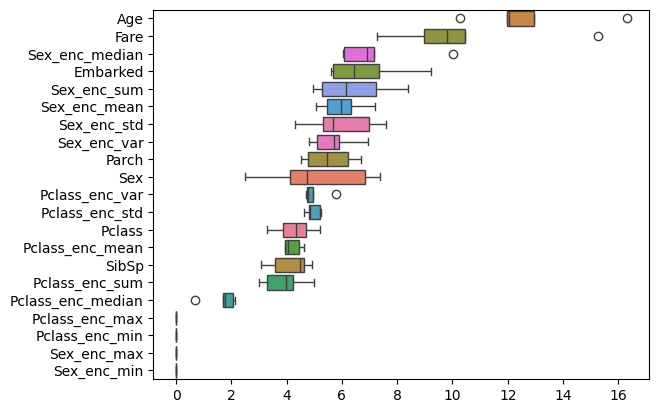

In [16]:
import pandas as pd

# CatBoost の feature_importances_ は model.get_feature_importance() で取得
feature_importances = []
for _, model in models:
    feature_importances.append(model.get_feature_importance())

feature_importances_df = pd.DataFrame(feature_importances, columns=USE_COL)

order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()

sns.boxplot(data=feature_importances_df, orient="h", order=order)

In [17]:
# テストデータに対する予測
test_X = test.select(USE_COL).to_pandas()

pred_list = []
for _, model in models:
    # predict_probaのクラス1（生存）の確率を取得
    pred_list.append(model.predict_proba(test_X)[:, 1])

pred = np.mean(pred_list, axis=0)
pred = (pred > 0.5).astype(int)
pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [18]:
submit_df = pl.DataFrame({"PassengerId": test["PassengerId"], "Survived": pred})
submit_df.write_csv(f"../../submit/{EXP_NAME}_oof{oof_score:.4f}.csv")